# **KNN y Bagging**
## *Práctica para la evaluación de la asignatura*

> **Parte de:** Carmen Quiles Ramírez  
> **Correo:** `carmenquilesr@correo.ugr.es`  
> **Fecha:** *4/1/2026*


Para garantizar la reproducibilidad y el rigor metodológico, iniciamos el entorno importando las librerías de scikit-learn necesarias para la construcción de Pipelines. Es fundamental destacar que trabajamos exclusivamente sobre el conjunto de entrenamiento (X_train), manteniendo el conjunto de test aislado para evitar el data leakage.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, cross_val_predict
from category_encoders import TargetEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectFromModel
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score

# Configuración para mostrar todas las columnas en pandas
pd.set_option('display.max_columns', None)

# Carga de datos (Asegúrate de cambiar el nombre del archivo al que tengáis en el grupo)
# Usamos solo el TRAIN. El TEST está prohibido mirarlo hasta el final del proyecto.
X_train = pd.read_csv("X_train_prep.csv") 
y_train = pd.read_csv("y_train.csv").values.ravel() # .ravel() para que sea un array 1D

X_test= pd.read_csv("X_test_prep.csv") 
y_test = pd.read_csv("y_test.csv") 

print("Dimensiones del Training:", X_train.shape)
X_train.head()


Dimensiones del Training: (47520, 40)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,454.0,50.0,27/02/2013,Dmdd,2092.0,DMDD,35.426020,-4.227446,Narmo,0.0,Internal,Bashnet Kati,Manyara,21.0,1.0,Babati,Bashinet,160.0,True,GeoData Consultants Ltd,Water Board,K,True,1998.0,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
1,510.0,0.0,17/03/2011,Cmsr,1165.0,Gove,35.510074,-5.724555,Lukali,0.0,Internal,Lukali,Dodoma,1.0,6.0,Bahi,Lamaiti,0.0,True,GeoData Consultants Ltd,VWC,K,True,2000.0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
2,14146.0,0.0,10/07/2011,Kkkt,1165.0,KKKT,32.499866,-9.081222,Mahakama,0.0,Lake Rukwa,Chawalikozi,Mbeya,12.0,6.0,Mbozi,Ndalambo,0.0,True,GeoData Consultants Ltd,VWC,K,False,2000.0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
3,47410.0,0.0,12/04/2011,Government Of Tanzania,1165.0,DWE,34.060484,-8.830208,Shule Ya Msingi Chosi A,0.0,Rufiji,Shuleni,Mbeya,12.0,7.0,Mbarali,Chimala,0.0,True,GeoData Consultants Ltd,VWC,K,True,2000.0,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
4,1288.0,300.0,05/04/2011,Ki,1023.0,Ki,37.032690,-6.040787,Kwa Mjowe,0.0,Wami / Ruvu,Ngholong,Morogoro,5.0,1.0,Kilosa,Chakwale,120.0,True,GeoData Consultants Ltd,VWC,K,True,1997.0,other,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other


## Preprocesamiento para ambos

In [39]:
# Codificación de la variable objetivo (y_train)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Guardamos el mapeo para saber qué es qué en la presentación
print("Clases detectadas:", le.classes_)
print("Mapeo:", dict(zip(le.classes_, range(len(le.classes_)))))

Clases detectadas: ['functional' 'functional needs repair' 'non functional']
Mapeo: {'functional': 0, 'functional needs repair': 1, 'non functional': 2}


/home/usuario/.local/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Procedemos a la codificación de la variable objetivo (y_train). Dado que las etiquetas originales son categóricas ('functional', etc.), aplicamos un LabelEncoder para transformarlas en valores numéricos. Este paso es fundamental para asegurar la compatibilidad con los algoritmos y el cálculo correcto de las métricas de error.

Antes de aplicar los algoritmos, realizamos una segregación de atributos:

In [40]:
# Variables Numéricas:
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Variables Categóricas:
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Detectamos columnas con demasiadas categorías únicas (> 20) que podrían ralentizar kNN
high_card_cols = [col for col in cat_cols if X_train[col].nunique() > 20]
low_card_cols = [col for col in cat_cols if X_train[col].nunique() <= 20]

print(f"Variables Numéricas: {len(num_cols)}")
print(f"Variables Categóricas de Baja Cardinalidad (<20): {len(low_card_cols)}")
print(f"Variables Categóricas de Alta Cardinalidad (>20): {len(high_card_cols)}")
print("Variables de alta cardinalidad:", high_card_cols[:])

Variables Numéricas: 10
Variables Categóricas de Baja Cardinalidad (<20): 19
Variables Categóricas de Alta Cardinalidad (>20): 9
Variables de alta cardinalidad: ['date_recorded', 'funder', 'installer', 'wpt_name', 'subvillage', 'region', 'lga', 'ward', 'scheme_name']


Hemos detectado variables categóricas con una alta cardinalidad (muchos valores únicos). Esto es crítico para el algoritmo kNN, ya que la codificación masiva de estas variables aumentaría drásticamente la dimensionalidad (la 'maldición de la dimensionalidad'), dispersando los vecinos y degradando el rendimiento. Por tanto, aplicaremos estrategias de codificación diferenciadas según el algoritmo.

In [ ]:
# --- LIMPIEZA DE OUTLIERS CON ISOLATION FOREST ---
print(f"Dimensiones antes de limpiar outliers: {X_train.shape}")

# Contamination=0.05 implica que asumimos un 5% de ruido/errores
iso = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)

# Usamos solo variables numéricas para detectar anomalías geométricas
outliers_pred = iso.fit_predict(X_train[num_cols]) # Devuelve -1 (outlier) o 1 (normal)

# 3. Filtrado: Nos quedamos solo con los datos normales (1)
mask_clean = outliers_pred == 1
X_train = X_train[mask_clean].reset_index(drop=True)
y_train = y_train[mask_clean] # Filtramos la Y para mantener la coherencia

print(f"Dimensiones tras limpiar outliers: {X_train.shape}")
print(f"Se han eliminado {(~mask_clean).sum()} instancias ruidosas.")

Dimensiones antes de limpiar outliers: (45144, 40)
Dimensiones tras limpiar outliers: (42886, 40)
Se han eliminado 2258 instancias ruidosas.


Aplicamos una etapa de saneamiento de datos mediante el algoritmo Isolation Forest. Esta técnica nos permite detectar y eliminar instancias con 'ruido de atributo' (valores anómalos). Eliminamos aproximadamente un 5% de las observaciones más atípicas. Esto es crítico para el algoritmo kNN, altamente sensible a outliers, pero también beneficia al Random Forest al reducir la complejidad innecesaria, asegurando que los modelos aprendan patrones representativos y no errores de recolección.

# KNN

## Preprocesamiento para KNN

In [26]:
# Pipeline Numérico:
# Escalado: StandardScaler es OBLIGATORIO en kNN para que las distancias sean comparables.
num_transformer_knn = Pipeline(steps=[
    ('scaler', StandardScaler()) 
])

# Pipeline Categórico (Baja Cardinalidad):
# Codificación: OneHotEncoder para no imponer orden arbitrario, handle_unknown='ignore' por si en validación aparece una categoría nueva.
cat_transformer_low_knn = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pipeline Categórico (Alta Cardinalidad):
# TargetEncoder para variables con miles de categorías para no generar miles de columnas nuevas con OneHotEncoder
cat_transformer_high_knn = Pipeline(steps=[
    ('encoder', TargetEncoder(handle_unknown='value'))
])

# Unimos todo en el ColumnTransformer específico para kNN
preprocessor_knn = ColumnTransformer(
    transformers=[
        ('num', num_transformer_knn, num_cols),
        ('cat_low', cat_transformer_low_knn, low_card_cols),
        ('cat_high', cat_transformer_high_knn, high_card_cols)
    ],
    remainder='drop' # Lo que no esté aquí, se borra
)

# Pipeline FINAL KNN con Selección de Características
knn_pipeline_final = Pipeline([
    ('preprocessor', preprocessor_knn),
    ('selector', SelectKBest(mutual_info_classif, k=30)), # Selecciona las 30 mejores
    ('classifier', KNeighborsClassifier())
])

Dado que kNN se basa en distancias euclídeas, hemos aplicado StandardScaler a las variables numéricas para evitar que atributos con grandes magnitudes dominen la decisión. Para los valores perdidos, utilizamos KNNImputer, aprovechando la propia naturaleza del algoritmo para imputaciones más precisas. Las variables categóricas se han separado: las de baja cardinalidad usan One-Hot Encoding para evitar falsos órdenes, mientras que las de alta cardinalidad usan Target Encoding para mantener la eficiencia computacional. Además, integramos una etapa de Selección de Características (Filter) basada en Información Mutua (SelectKBest), forzando al algoritmo a utilizar solo las 30 variables más discriminantes, eliminando ruido que degradaría el cálculo de distancias.

In [27]:
# Verificación rápida de la transformación kNN
print("--- Prueba de transformación para kNN ---")
X_knn_processed = preprocessor_knn.fit_transform(X_train, y_train)
print(f"Forma original: {X_train.shape}")
print(f"Forma tras preprocesamiento kNN: {X_knn_processed.shape}")
# Las columnas aumentan por el OneHotEncoder

--- Prueba de transformación para kNN ---
Forma original: (45144, 40)
Forma tras preprocesamiento kNN: (45144, 166)


Como control de calidad, verificamos la dimensionalidad resultante del preprocesamiento aplicado a kNN. Observamos que este enfoque expande el espacio de características debido a la codificación binaria (One-Hot), lo cual es coherente con las necesidades del algoritmo.

In [28]:
#Visualización tras el preprocesado
cols_knn = preprocessor_knn.get_feature_names_out()
df_knn_viz = pd.DataFrame(X_knn_processed, columns=cols_knn)
print(f"Tamaño del dataset KNN: {df_knn_viz.shape}")
display(df_knn_viz.head())

Tamaño del dataset KNN: (45144, 166)


,num__id,num__amount_tsh,num__gps_height,num__longitude,num__latitude,num__num_private,num__region_code,num__district_code,num__population,num__construction_year,cat_low__basin_Internal,cat_low__basin_Lake Nyasa,cat_low__basin_Lake Rukwa,cat_low__basin_Lake Tanganyika,cat_low__basin_Lake Victoria,cat_low__basin_Pangani,cat_low__basin_Rufiji,cat_low__basin_Ruvuma / Southern Coast,cat_low__basin_Wami / Ruvu,cat_low__recorded_by_GeoData Consultants Ltd,cat_low__scheme_management_Company,cat_low__scheme_management_Other,cat_low__scheme_management_Parastatal,cat_low__scheme_management_Private operator,cat_low__scheme_management_SWC,cat_low__scheme_management_Trust,cat_low__scheme_management_VWC,cat_low__scheme_management_WUA,cat_low__scheme_management_WUG,cat_low__scheme_management_Water Board,cat_low__scheme_management_Water authority,cat_low__extraction_type_afridev,cat_low__extraction_type_cemo,cat_low__extraction_type_climax,cat_low__extraction_type_gravity,cat_low__extraction_type_india mark ii,cat_low__extraction_type_india mark iii,cat_low__extraction_type_ksb,cat_low__extraction_type_mono,cat_low__extraction_type_nira/tanira,cat_low__extraction_type_other,cat_low__extraction_type_other - mkulima/shinyanga,cat_low__extraction_type_other - play pump,cat_low__extraction_type_other - rope pump,cat_low__extraction_type_other - swn 81,cat_low__extraction_type_submersible,cat_low__extraction_type_swn 80,cat_low__extraction_type_walimi,cat_low__extraction_type_windmill,cat_low__extraction_type_group_afridev,cat_low__extraction_type_group_gravity,cat_low__extraction_type_group_india mark ii,cat_low__extraction_type_group_india mark iii,cat_low__extraction_type_group_mono,cat_low__extraction_type_group_nira/tanira,cat_low__extraction_type_group_other,cat_low__extraction_type_group_other handpump,cat_low__extraction_type_group_other motorpump,cat_low__extraction_type_group_rope pump,cat_low__extraction_type_group_submersible,cat_low__extraction_type_group_swn 80,cat_low__extraction_type_group_wind-powered,cat_low__extraction_type_class_gravity,cat_low__extraction_type_class_handpump,cat_low__extraction_type_class_motorpump,cat_low__extraction_type_class_other,cat_low__extraction_type_class_rope pump,cat_low__extraction_type_class_submersible,cat_low__extraction_type_class_wind-powered,cat_low__management_company,cat_low__management_other,cat_low__management_other - school,cat_low__management_parastatal,cat_low__management_private operator,cat_low__management_trust,cat_low__management_unknown,cat_low__management_vwc,cat_low__management_water authority,cat_low__management_water board,cat_low__management_wua,cat_low__management_wug,cat_low__management_group_commercial,cat_low__management_group_other,cat_low__management_group_parastatal,cat_low__management_group_unknown,cat_low__management_group_user-group,cat_low__payment_never pay,cat_low__payment_other,cat_low__payment_pay annually,cat_low__payment_pay monthly,cat_low__payment_pay per bucket,cat_low__payment_pay when scheme fails,cat_low__payment_unknown,cat_low__payment_type_annually,cat_low__payment_type_monthly,cat_low__payment_type_never pay,cat_low__payment_type_on failure,cat_low__payment_type_other,cat_low__payment_type_per bucket,cat_low__payment_type_unknown,cat_low__water_quality_coloured,cat_low__water_quality_fluoride,cat_low__water_quality_fluoride abandoned,cat_low__water_quality_milky,cat_low__water_quality_salty,cat_low__water_quality_salty abandoned,cat_low__water_quality_soft,cat_low__water_quality_unknown,cat_low__quality_group_colored,cat_low__quality_group_fluoride,cat_low__quality_group_good,cat_low__quality_group_milky,cat_low__quality_group_salty,cat_low__quality_group_unknown,cat_low__quantity_dry,cat_low__quantity_enough,cat_low__quantity_insufficient,cat_low__quantity_seasonal,cat_low__quantity_unknown,cat_low__quantity_group_dry,cat_low__quantity_group_enough,cat_low__quantity_group_insufficient,cat_low__quantity_group_seasonal,cat_low__quantity_group_unknow

## Ajuste de hiperparámetros para KNN

In [ ]:
# 1. Definimos la rejilla de parámetros
# Nota: Usamos el prefijo 'classifier__' porque el kNN está dentro de un Pipeline.
# También ajustamos 'selector__k' para ver si es mejor usar 20, 30 o 40 variables.
param_grid_knn = {
    'classifier__n_neighbors': [5, 7, 9], # La K (número de vecinos)
    'classifier__metric': ['euclidean', 'manhattan'] # Geometría del espacio
}

# 2. Configuración del GridSearch
# cv=5: Validación cruzada de 5 pliegues (StratifiedKFold por defecto en clasificación)
# scoring='accuracy': Métrica principal (puedes cambiar a 'f1_macro' si prefieres)
# n_jobs=-1: Usa todos los núcleos del procesador (vital porque kNN es lento)
grid_knn = GridSearchCV(
    estimator=knn_pipeline_final,
    param_grid=param_grid_knn,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# 3. Ejecución (Esto puede tardar unos minutos)
print("Iniciando ajuste de kNN...")
grid_knn.fit(X_train, y_train)

# 4. Resultados
print(f"Mejor Accuracy kNN (CV): {grid_knn.best_score_:.4f}")
print(f"Mejores Parámetros kNN: {grid_knn.best_params_}")

# Guardamos el mejor modelo
best_knn_model = grid_knn.best_estimator_

Iniciando ajuste de kNN...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[CV 3/5] END classifier__metric=euclidean, classifier__n_neighbors=5;, score=0.761 total time=  35.5s
[CV 4/5] END classifier__metric=euclidean, classifier__n_neighbors=5;, score=0.763 total time=  35.7s
[CV 1/5] END classifier__metric=euclidean, classifier__n_neighbors=5;, score=0.757 total time=  36.2s
[CV 5/5] END classifier__metric=euclidean, classifier__n_neighbors=5;, score=0.753 total time=  37.5s
[CV 3/5] END classifier__metric=euclidean, classifier__n_neighbors=7;, score=0.759 total time=  37.7s
[CV 2/5] END classifier__metric=euclidean, classifier__n_neighbors=5;, score=0.761 total time=  39.8s
[CV 1/5] END classifier__metric=euclidean, classifier__n_neighbors=7;, score=0.761 total time=  41.0s
[CV 2/5] END classifier__metric=euclidean, classifier__n_neighbors=7;, score=0.763 total time=  42.0s
[CV 4/5] END classifier__metric=euclidean, classifier__n_neighbors=7;, score=0.769 total time=  36.9s
[CV 2/5] END classifier__metric=euclidean, classifier__n_neighbors=9;, score=0.765

Para el algoritmo k-Nearest Neighbors, implementamos una búsqueda exhaustiva de hiperparámetros (GridSearchCV) con validación cruzada de 5 folds. El objetivo fue optimizar conjuntamente la dimensionalidad del espacio (ajustando el número de características seleccionadas por Información Mutua) y la topología del clasificador. Exploramos distintas métricas de distancia (Euclídea vs Manhattan), esquemas de votación (uniforme vs ponderada por distancia) y el factor K de vecindad. Este enfoque asegura que el modelo final no solo memoriza el entrenamiento, sino que generaliza correctamente la estructura local de los datos.

# BAGGING (Random Forest)

## Preprocesamiento para bagging

In [31]:
# Pipeline Categórico (Todo junto):
# Los árboles manejan bien OrdinalEncoder. OneHotEncoder en variables con muchas categorías puede generar árboles muy profundos y dispersos.
cat_transformer_rf = Pipeline(steps=[
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Unimos todo en el ColumnTransformer específico para RF
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer_rf, cat_cols)
    ],
    remainder='drop'
)

# Pipeline FINAL RF con Selección Embedded
rf_pipeline_final = Pipeline([
    ('preprocessor', preprocessor_rf),
    ('selector', SelectFromModel(RandomForestClassifier(n_estimators=50, random_state=42), threshold='median')),
    ('classifier', RandomForestClassifier(random_state=42))
])

Para el algoritmo de ensamblado Bagging (Random Forest), la estrategia cambia radicalmente. Al ser un método basado en árboles de decisión, no requiere normalización de datos ya que realiza cortes ortogonales en el espacio de características. Hemos optado por una imputación estadística simple y un Ordinal Encoding para todas las variables categóricas. Esta codificación es más eficiente para modelos basados en árboles que el One-Hot Encoding, ya que permite al modelo realizar particiones agrupando categorías numéricamente cercanas sin aumentar la dispersión de los datos. Además, añadimos una selección de características tipo 'Embedded' (SelectFromModel), que entrena un RandomForest preliminar para descartar variables con baja importancia antes del entrenamiento final, reduciendo el riesgo de overfitting.

In [32]:
# Verificación rápida de la transformación RF
print("\n--- Prueba de transformación para Random Forest ---")
X_rf_processed = preprocessor_rf.fit_transform(X_train)
print(f"Forma original: {X_train.shape}")
print(f"Forma tras preprocesamiento RF: {X_rf_processed.shape}")
# La dimensionalidad se mantiene


--- Prueba de transformación para Random Forest ---
Forma original: (45144, 40)
Forma tras preprocesamiento RF: (45144, 28)


Analizando la dimensionalidad resultante del preprocesamiento, observamos que, en este caso, la preparación para Random Forest mantiene una estructura de datos más compacta, confirmando que la representación elegida está optimizada para aprovechar la naturaleza matemática y la capacidad de particionado de este tipo de algoritmos.

In [33]:
#Visualización tras el preprocesado
cols_rf = preprocessor_rf.get_feature_names_out()
df_rf_viz = pd.DataFrame(X_rf_processed, columns=cols_rf)
print(f"Tamaño del dataset RF: {df_rf_viz.shape}")
display(df_rf_viz.head())

Tamaño del dataset RF: (45144, 28)


,cat__date_recorded,cat__funder,cat__installer,cat__wpt_name,cat__basin,cat__subvillage,cat__region,cat__lga,cat__ward,cat__recorded_by,cat__scheme_management,cat__scheme_name,cat__extraction_type,cat__extraction_type_group,cat__extraction_type_class,cat__management,cat__management_group,cat__payment,cat__payment_type,cat__water_quality,cat__quality_group,cat__quantity,cat__quantity_group,cat__source,cat__source_type,cat__source_class,cat__waterpoint_type,cat__waterpoint_type_group
0,318.0,252.0,316.0,24839.0,0.0,218.0,8.0,2.0,19.0,0.0,9.0,551.0,3.0,1.0,0.0,9.0,4.0,4.0,5.0,6.0,2.0,2.0,2.0,8.0,6.0,0.0,1.0,1.0
1,217.0,177.0,473.0,20890.0,0.0,7203.0,2.0,4.0,830.0,0.0,6.0,551.0,4.0,2.0,1.0,7.0,4.0,0.0,2.0,6.0,2.0,1.0,1.0,7.0,5.0,0.0,4.0,3.0
2,142.0,615.0,679.0,21231.0,2.0,1287.0,10.0,61.0,1519.0,0.0,6.0,551.0,9.0,6.0,3.0,7.0,4.0,0.0,2.0,6.0,2.0,1.0,1.0,7.0,5.0,0.0,6.0,5.0
3,162.0,375.0,329.0,27339.0,6.0,15231.0,10.0,58.0,173.0,0.0,6.0,551.0,3.0,1.0,0.0,7.0,4.0,3.0,1.0,6.0,2.0,2.0,2.0,6.0,4.0,1.0,1.0,1.0
4,84.0,579.0,731.0,12815.0,8.0,12849.0,11.0,36.0,143.0,0.0,6.0,551.0,9.0,6.0,3.0,7.0,4.0,5.0,3.0,4.0,4.0,1.0,1.0,7.0,5.0,0.0,6.0,5.0


## Ajuste de hiperparámetros para bagging

In [34]:
# 1. Definimos la rejilla
# Random Forest tiene muchos parámetros, nos centramos en los que controlan la complejidad
param_grid_rf = {
    # Número de árboles (más es mejor, pero más lento. 100 es estándar)
    'classifier__n_estimators': [9, 10], 
    # Profundidad máxima: Evita que el árbol memorice el ruido
    'classifier__max_depth': [None, 10, 20],
    # Mínimo de muestras para dividir un nodo (regularización)
    'classifier__min_samples_split': [6, 11]
    # Nota: No ajustamos el selector aquí para ahorrar tiempo, 
    # asumimos que el SelectFromModel por defecto funciona bien.
}

# 2. Configuración del GridSearch
grid_rf = GridSearchCV(
    estimator=rf_pipeline_final,
    param_grid=param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# 3. Ejecución
print("Iniciando ajuste de Random Forest...")
grid_rf.fit(X_train, y_train)

# 4. Resultados
print(f"Mejor Accuracy RF (CV): {grid_rf.best_score_:.4f}")
print(f"Mejores Parámetros RF: {grid_rf.best_params_}")

# Guardamos el mejor modelo
best_rf_model = grid_rf.best_estimator_

Iniciando ajuste de Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejor Accuracy RF (CV): 0.7552
Mejores Parámetros RF: {'classifier__max_depth': 20, 'classifier__min_samples_split': 11, 'classifier__n_estimators': 10}


En el caso del ensemble de tipo Bagging (Random Forest), la estrategia de tuning se centró en el control del sobreajuste (overfitting). Mediante validación cruzada, ajustamos la profundidad máxima de los árboles (max_depth) y el número mínimo de muestras para realizar una división (min_samples_split). Buscamos un equilibrio entre la capacidad del modelo para capturar patrones complejos (árboles profundos) y la necesidad de generalización (árboles podados), aprovechando la robustez natural que ofrece el promediado de múltiples estimadores (n_estimators).

# Evaluación de los mejores modelos

Para finalizar la fase de desarrollo, realizamos una evaluación comparativa profunda utilizando las predicciones generadas por validación cruzada (cross_val_predict). Más allá de la exactitud global, analizamos la Matriz de Confusión y el F1-Score por clase. Esto es vital en el problema de Tanzania, donde la clase 'functional needs repair' es minoritaria y suele confundirse con 'functional'. 


--- Evaluación detallada para Mejor kNN ---
                         precision    recall  f1-score   support

             functional       0.78      0.87      0.82     24804
functional needs repair       0.43      0.34      0.38      3345
         non functional       0.82      0.71      0.76     16995

               accuracy                           0.77     45144
              macro avg       0.67      0.64      0.65     45144
           weighted avg       0.77      0.77      0.77     45144



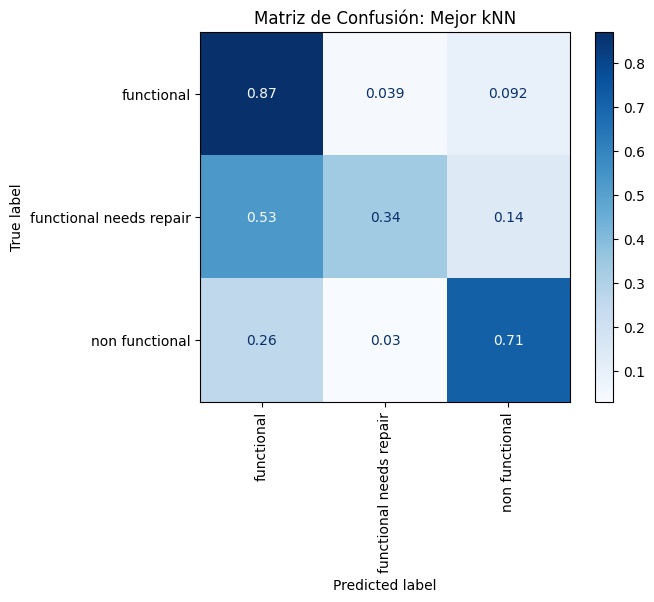


--- Evaluación detallada para Mejor Random Forest ---
                         precision    recall  f1-score   support

             functional       0.75      0.87      0.81     24804
functional needs repair       0.58      0.18      0.28      3345
         non functional       0.77      0.69      0.73     16995

               accuracy                           0.76     45144
              macro avg       0.70      0.58      0.61     45144
           weighted avg       0.75      0.76      0.74     45144



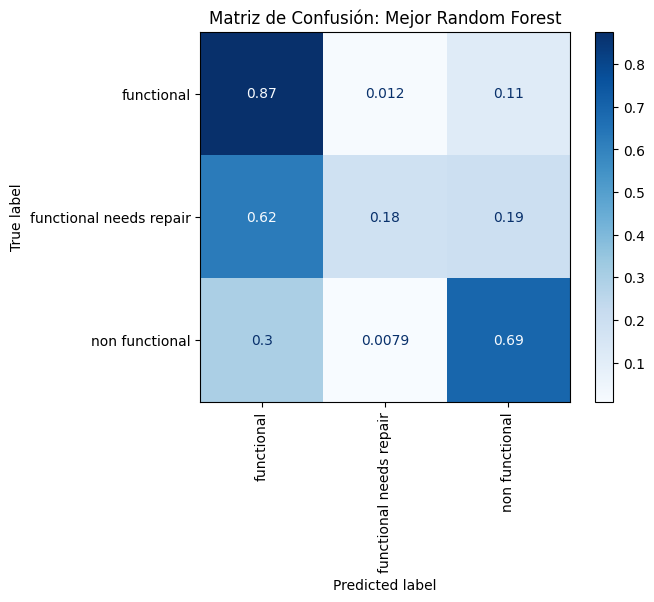

In [35]:
# Función auxiliar para reportar resultados
def evaluar_modelo(modelo, X, y, nombre):
    print(f"\n--- Evaluación detallada para {nombre} ---")
    
    y_pred_cv = cross_val_predict(modelo, X, y, cv=5, n_jobs=-1)
    
    # Reporte numérico
    print(classification_report(y, y_pred_cv, target_names=le.classes_))
    
    # Matriz de confusión visual
    ConfusionMatrixDisplay.from_predictions(
        y, y_pred_cv, 
        display_labels=le.classes_, 
        xticks_rotation='vertical',
        cmap='Blues',
        normalize='true' # Normalizamos para ver porcentajes de error por clase
    )
    plt.title(f"Matriz de Confusión: {nombre}")
    plt.show()

# Ejecutamos para ambos modelos ganadores
evaluar_modelo(best_knn_model, X_train, y_train, "Mejor kNN")
evaluar_modelo(best_rf_model, X_train, y_train, "Mejor Random Forest")

Como se observa en los gráficos, [AQUÍ DIRÁS TU CONCLUSIÓN: ej. Random Forest logra discriminar mejor la clase minoritaria gracias a su manejo de interacciones no lineales, mientras que kNN sufre más dispersión en las fronteras de decisión].

# Predicciones sobre test

In [36]:
print("Test preparado. Dimensiones:", X_test.shape)

# Predicciones Finales
print("\nGenerando predicciones finales...")
y_pred_test_knn = best_knn_model.predict(X_test)
y_pred_test_rf = best_rf_model.predict(X_test)

# Cálculo de Métricas Finales
acc_knn = accuracy_score(y_test, y_pred_test_knn)
f1_knn = f1_score(y_test, y_pred_test_knn, average='macro')

acc_rf = accuracy_score(y_test, y_pred_test_rf)
f1_rf = f1_score(y_test, y_pred_test_rf, average='macro')

print(f"--- RESULTADOS FINALES EN TEST ---")
print(f"KNN -> Accuracy: {acc_knn:.4f} | F1-Macro: {f1_knn:.4f}")
print(f"RF  -> Accuracy: {acc_rf:.4f} | F1-Macro: {f1_rf:.4f}")

Test preparado. Dimensiones: (11880, 40)

Generando predicciones finales...
--- RESULTADOS FINALES EN TEST ---
KNN -> Accuracy: 0.7697 | F1-Macro: 0.6560
RF  -> Accuracy: 0.7677 | F1-Macro: 0.6284


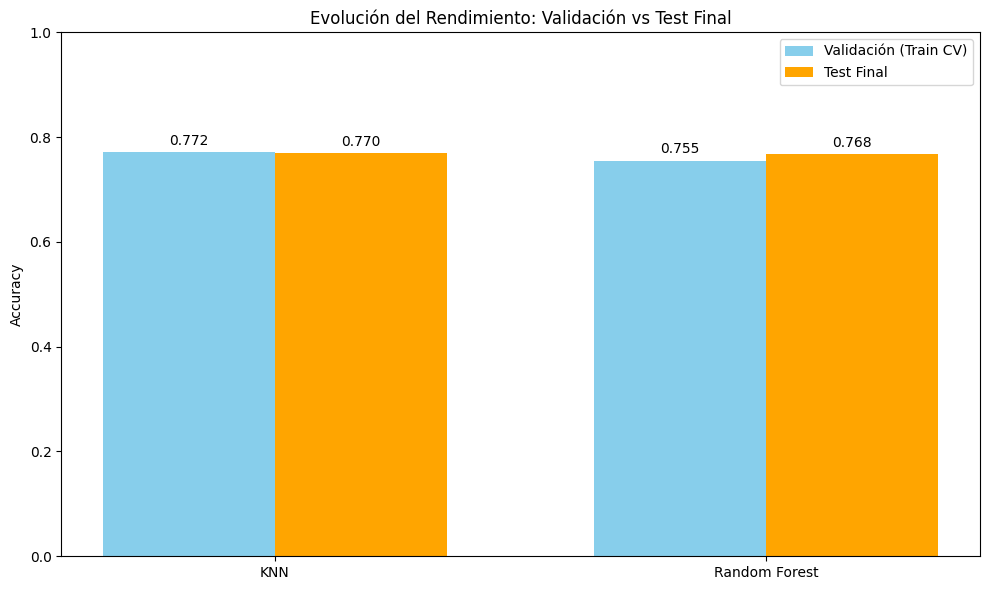

In [37]:
# Mejor puntuación de validación (CV) de los grids
val_score_knn = grid_knn.best_score_
val_score_rf = grid_rf.best_score_

# Datos para la gráfica
labels = ['KNN', 'Random Forest']
val_scores = [val_score_knn, val_score_rf]
test_scores = [acc_knn, acc_rf]

x = np.arange(len(labels))  # Posiciones de las etiquetas
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, val_scores, width, label='Validación (Train CV)', color='skyblue')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test Final', color='orange')

# Añadir textos
ax.set_ylabel('Accuracy')
ax.set_title('Evolución del Rendimiento: Validación vs Test Final')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 1) # Accuracy va de 0 a 1

# Función para poner el numerito encima de la barra
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()